In [84]:
import openmeteo_requests
import requests_cache
import pandas as pd
from retry_requests import retry
import scipy.stats as stats
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

In [85]:
# Setup the API client with cache and retry
cache_session = requests_cache.CachedSession('.cache', expire_after=3600)
retry_session = retry(cache_session, retries=5, backoff_factor=0.2)
openmeteo = openmeteo_requests.Client(session=retry_session)

# Define parameters
url = "https://historical-forecast-api.open-meteo.com/v1/forecast"
params = {
    "latitude": 52.37,
    "longitude": 4.89,
    "start_date": "2021-08-10",
    "end_date": "2025-04-23",
    "hourly": "temperature_2m",
    "daily": "temperature_2m_mean",
    "timezone": "Europe/Amsterdam" 
}

# Make the API call
responses = openmeteo.weather_api(url, params=params)
response = responses[0]

print(f"Elevation: {response.Elevation()} masl")
print(f"Timezone: {response.Timezone()} ({response.TimezoneAbbreviation()})")
print(f"Timezone difference to GMT+0: {response.UtcOffsetSeconds()} seconds")


Elevation: 11.0 masl
Timezone: b'Europe/Amsterdam' (b'GMT+2')
Timezone difference to GMT+0: 7200 seconds


In [86]:
# hourly data
hourly = response.Hourly()
hourly_temperature = hourly.Variables(0).ValuesAsNumpy()

# Create a DataFrame with the hourly data
hourly_data = {
    "date": pd.date_range(
        start=pd.to_datetime(hourly.Time(), unit="s", utc=True),
        end=pd.to_datetime(hourly.TimeEnd(), unit="s", utc=True),
        freq=pd.Timedelta(seconds=hourly.Interval()),
        inclusive="left"
    ),
    "temperature_2m": hourly_temperature
}

# Construct DataFrame
hourly_dataframe = pd.DataFrame(data=hourly_data)


print(hourly_dataframe)


                           date  temperature_2m
0     2021-08-09 22:00:00+00:00       15.678500
1     2021-08-09 23:00:00+00:00       15.478500
2     2021-08-10 00:00:00+00:00       15.078500
3     2021-08-10 01:00:00+00:00       14.678500
4     2021-08-10 02:00:00+00:00       14.878500
...                         ...             ...
32467 2025-04-23 17:00:00+00:00       15.267500
32468 2025-04-23 18:00:00+00:00       12.517500
32469 2025-04-23 19:00:00+00:00       13.967500
32470 2025-04-23 20:00:00+00:00       13.617499
32471 2025-04-23 21:00:00+00:00       12.467500

[32472 rows x 2 columns]


In [87]:
# Process daily data
daily = response.Daily()
daily_temperatures = daily.Variables(0).ValuesAsNumpy()
daily_data = {
    "date": pd.date_range(
        start=pd.to_datetime(daily.Time(), unit="s", utc=True),
        end=pd.to_datetime(daily.TimeEnd(), unit="s", utc=True),
        freq=pd.Timedelta(seconds=daily.Interval()),
        inclusive="left"
    ),
    "temperature_2m_mean": daily_temperatures
}

daily_dataframe = pd.DataFrame(daily_data)
daily_dataframe = daily_dataframe.set_index(pd.to_datetime(daily_dataframe['date'])).dropna()
print(daily_dataframe.head())

                                               date  temperature_2m_mean
date                                                                    
2021-08-09 22:00:00+00:00 2021-08-09 22:00:00+00:00            17.211832
2021-08-10 22:00:00+00:00 2021-08-10 22:00:00+00:00            18.174332
2021-08-11 22:00:00+00:00 2021-08-11 22:00:00+00:00            18.695166
2021-08-12 22:00:00+00:00 2021-08-12 22:00:00+00:00            18.261831
2021-08-13 22:00:00+00:00 2021-08-13 22:00:00+00:00            18.165997


In [88]:
print("Starting time：", daily_dataframe.index.min())

Starting time： 2021-08-09 22:00:00+00:00


In [89]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

In [90]:
decompose_result = seasonal_decompose(
    daily_dataframe['temperature_2m_mean'],
    model='additive',
    period=365
)

In [91]:
trend = decompose_result.trend
seasonal = decompose_result.seasonal
residual = decompose_result.resid

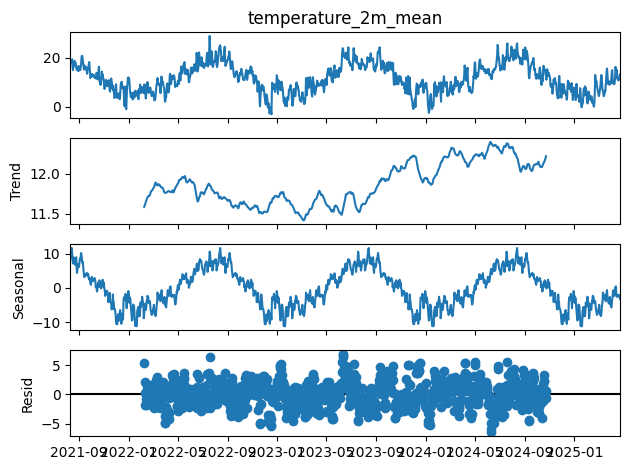

In [92]:
decompose_result.plot()
plt.tight_layout()
plt.show()

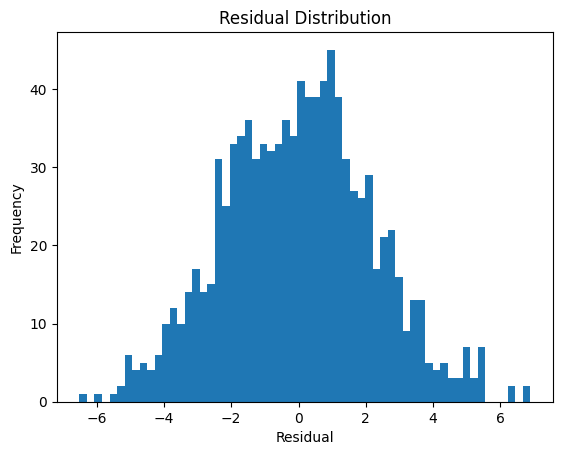

In [93]:
plt.hist(residual.dropna(), bins=60)
plt.title("Residual Distribution")
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.show()

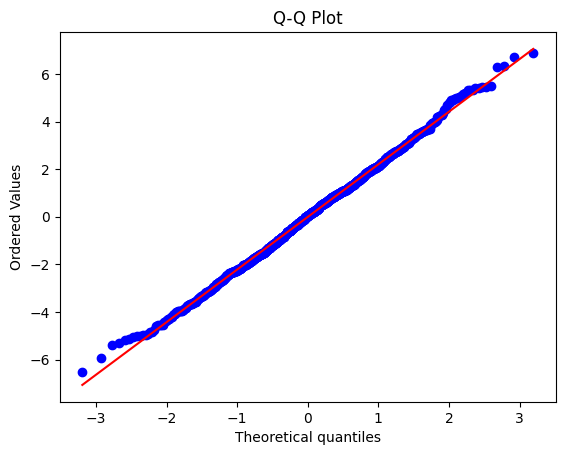

In [94]:
plt.figure()
stats.probplot(residual.dropna(), dist="norm", plot=plt)
plt.title("Q-Q Plot")
plt.show()

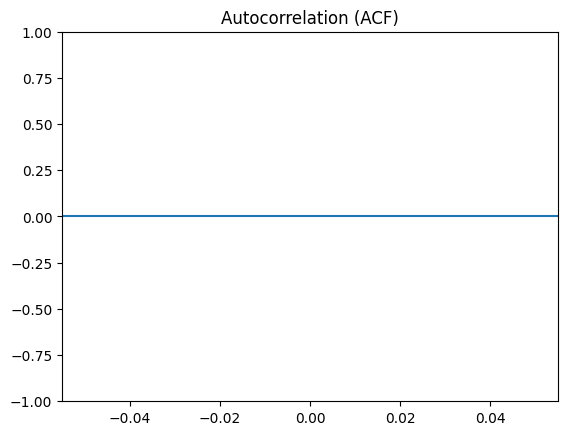

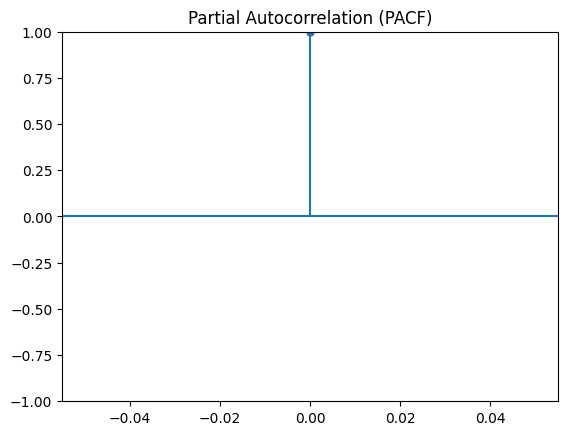

ADF Statistic: -8.945826407714467
p-value: 8.994608662740547e-15
Critical Values: {'1%': np.float64(-3.4370266558635914), '5%': np.float64(-2.864487711945291), '10%': np.float64(-2.5683395116993872)}


In [ ]:
plot_acf(residual, lags=40)
plt.title("Autocorrelation (ACF)")
plt.show()

plot_pacf(residual, lags=40, method="ywm")
plt.title("Partial Autocorrelation (PACF)")
plt.show()

adf_result = adfuller(residual.dropna(), autolag='AIC')
print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])
print("Critical Values:", adf_result[4])

In [98]:
import numpy as np
from scipy.optimize import curve_fit

# define the model function
def model_fit(x, a, b, a1, b1):
    omega = 2 * np.pi / 365.25  
    return a + b * x + a1 * np.cos(omega * x) + b1 * np.sin(omega * x)

# Transform the date to ordinal for fitting
first_ord = daily_dataframe.index[0].toordinal()
xdata = np.array([date.toordinal() - first_ord for date in daily_dataframe.index])
ydata = daily_dataframe['temperature_2m_mean']


params_all, cov = curve_fit(model_fit, xdata, ydata, method='lm')

# Calculate the fitted values and residuals
daily_dataframe['model'] = model_fit(xdata, *params_all)
daily_dataframe['residuals'] = daily_dataframe['temperature_2m_mean'] - daily_dataframe['model']

print("Estimated parameters:", params_all)


Estimated parameters: [ 1.14147836e+01  7.17758515e-04  6.83602482e+00 -1.89226664e+00]


In [47]:
from sklearn.linear_model import LinearRegression

In [ ]:
T_hat = daily_dataframe["residuals"].dropna()
residuals_lag = T_hat.shift(1).dropna()
residuals_current = T_hat[1:]

X = residuals_lag.values.reshape(-1, 1)
y = residuals_current.values

model = LinearRegression().fit(X, y)
gamma = model.coef_[0]
kappa = 1 - gamma

reg_residuals = y - model.predict(X)
sigma = np.std(reg_residuals)

print("Estimated parameters:")
print(f"gamma: {gamma}, kappa: {kappa}, sigma: {sigma}")


Estimated parameters:
gamma: 0.7928816155592223, kappa: 0.20711838444077768, sigma: 1.7648403025150712


In [49]:
mu_bar = daily_dataframe['model'].values

In [50]:
def fourier_volatility_model(t, V, U, *coeffs):
    omega = 2 * np.pi / 365.25
    I = J = len(coeffs) // 2
    sin_terms = sum(coeffs[i] * np.sin((i + 1) * omega * t) for i in range(I))
    cos_terms = sum(coeffs[I + j] * np.cos((j + 1) * omega * t) for j in range(J))
    return V + U * t + sin_terms + cos_terms

In [51]:
rolling_std = T_hat.rolling(window=30, center=True).std().dropna()
t = np.arange(len(rolling_std))
I = J = 2
n_params = 2 + I + J  # V, U, c1...cI, d1...dJ
initial_guess = np.zeros(n_params)
params, _ = curve_fit(fourier_volatility_model, t, rolling_std.values, p0=initial_guess)

# Calculate the fitted values
fitted_volatility = fourier_volatility_model(np.arange(len(mu_bar)), *params)

In [ ]:
mu_bar = daily_dataframe['model'].values
def simulate_temperature_paths(mu_bar, sigma_t, kappa, n_sim, seed=42):
    np.random.seed(seed)
    n = len(mu_bar)
    paths = np.zeros((n_sim, n))
    paths[:, 0] = mu_bar[0]  # Initialize at trend

    for sim in range(n_sim):
        for i in range(1, n):
            d_mu = mu_bar[i] - mu_bar[i - 1]
            mean_revert = kappa * (mu_bar[i - 1] - paths[sim, i - 1])
            noise = sigma_t[i] * np.random.randn()
            paths[sim, i] = paths[sim, i - 1] + d_mu + mean_revert + noise

    return paths

In [53]:
n_simulations = 20
simulated_paths = simulate_temperature_paths(mu_bar, fitted_volatility, kappa, n_sim=n_simulations)


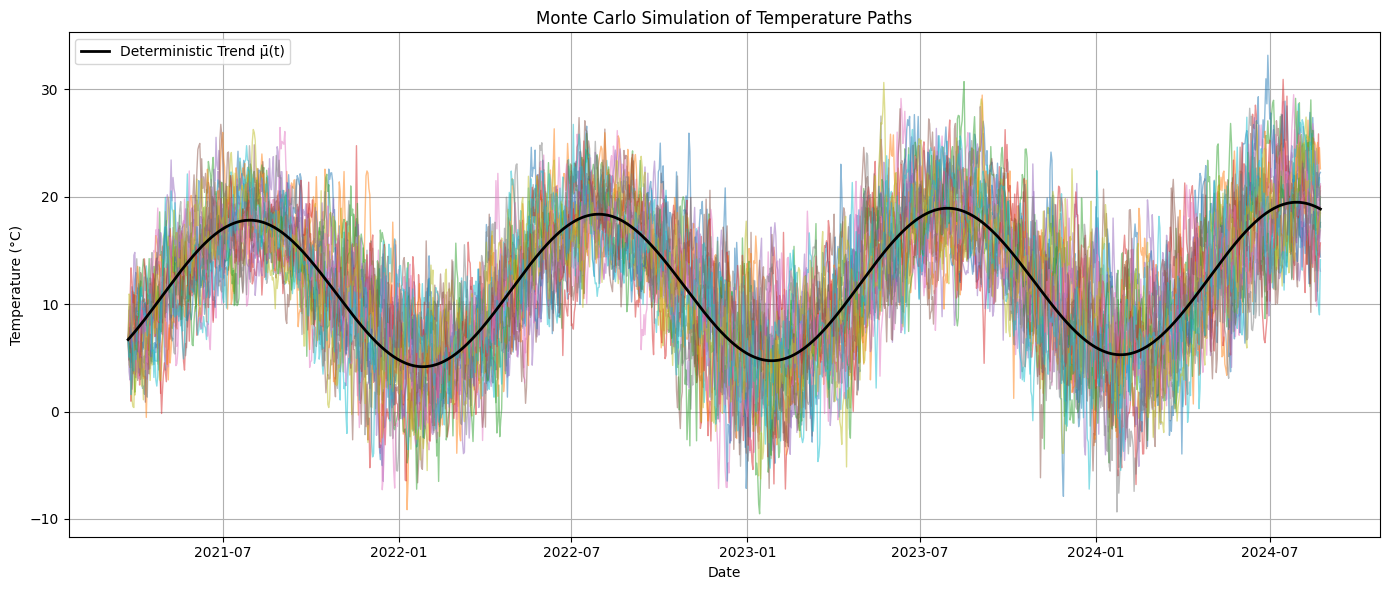

In [55]:
dates = daily_dataframe.index
plt.figure(figsize=(14, 6))
for i in range(n_simulations):
    plt.plot(dates, simulated_paths[i], alpha=0.5, linewidth=1)
plt.plot(dates, mu_bar, label="Deterministic Trend μ̄(t)", color='black', linewidth=2)
plt.title("Monte Carlo Simulation of Temperature Paths")
plt.xlabel("Date")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
T_base = 18
DD = np.sum(np.maximum(simulate_temperature_paths - T_base, 0))

def call_option_with_cap(DD, K, alpha, C):
    return min(alpha * max(DD - K, 0), C)

def put_option_with_floor(DD, K, alpha, F):
    return min(alpha * max(K - DD, 0), F)

def collar_option(DD, K1, K2, alpha, beta, C, F):
    long_call = min(alpha * max(DD - K1, 0), C)
    short_put = min(beta * max(K2 - DD, 0), F)
    return long_call - short_put


In [56]:
simulated_paths

array([[ 6.69862042,  7.81695082,  7.42428592, ..., 14.5170459 ,
        15.46646597, 14.38988833],
       [ 6.69862042,  7.27820561,  4.08974921, ..., 19.02920826,
        16.12795969, 18.49360529],
       [ 6.69862042,  6.22757301,  5.87390804, ..., 15.44570733,
        16.85261184, 17.60963173],
       ...,
       [ 6.69862042,  9.7531354 ,  9.83491343, ..., 20.08062037,
        20.8368963 , 17.21065574],
       [ 6.69862042, 10.94406664, 10.73801236, ..., 17.51665989,
        17.94501689, 18.72712938],
       [ 6.69862042,  5.07633141,  5.38959005, ...,  9.82702454,
         9.00262977, 14.13730571]], shape=(20, 1249))

In [66]:
#MC methods to compute the price at time t of an HDD call option 
def hdd_call_option_price(paths,r,K, T = 18,dt = 1,N = 100):
    n_simulations, n = paths.shape
    HDD = np.sum(np.maximum(K - paths,0), axis=0)
    payoffs = N * np.maximum(HDD - K, 0) 
    return np.exp(-r * n_simulations * dt) * np.mean(payoffs)
    

In [68]:
H = hdd_call_option_price(simulated_paths, r=0.05, K=18, T=18, dt=1, N=100)

print(f"HDD‐call price ≈ {H:.2f}")

HDD‐call price ≈ 4099.74
